In [1]:
#pip install -r ../requirements.txt

In [2]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer,AutoTokenizer
import torch
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score,roc_curve, auc,f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [3]:
model = AutoModelForSequenceClassification.from_pretrained("../models/diffcse-roberta-base-trans", num_labels=1)
metric = evaluate.load("accuracy")
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=7)

Some weights of the model checkpoint at ../models/diffcse-roberta-base-trans were not used when initializing RobertaForSequenceClassification: ['aux_bert.encoder.layer.11.attention.self.key.bias', 'generator.roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'aux_bert.encoder.layer.11.output.LayerNorm.bias', 'aux_bert.encoder.layer.6.output.dense.weight', 'aux_bert.encoder.layer.5.attention.self.key.bias', 'aux_bert.encoder.layer.8.output.dense.bias', 'aux_bert.encoder.layer.1.output.LayerNorm.bias', 'aux_bert.encoder.layer.1.attention.output.dense.bias', 'aux_bert.encoder.layer.1.attention.output.LayerNorm.weight', 'aux_bert.encoder.layer.6.attention.self.query.weight', 'aux_bert.encoder.layer.8.attention.output.LayerNorm.bias', 'aux_bert.encoder.layer.5.output.LayerNorm.weight', 'aux_bert.encoder.layer.8.attention.output.dense.weight', 'aux_bert.encoder.layer.10.intermediate.dense.bias', 'aux_bert.encoder.layer.7.attention.self.query.weight', 'generator.roberta.encoder.layer.1

In [4]:
dataset_test = pd.read_parquet(r'val_rus.parquet', engine='fastparquet')
dataset_test

,text,label
0,В связи с этим в подпрограмму включены следующ...,1
1,В последнее время я её нечасто видел.,1
2,"Лермонтов прибыл на Кавказ, чтобы задействоват...",0
3,Хотите фруктового сока?,1
4,"Однако, в рамках существующих условий «...",0
...,...,...
21506,"Нет, не я, а ты!",1
21507,"Кинолента ""Бегущий По Огню"" названа лучшей фил...",0
21508,В настоящее время в городе работает более 200 ...,0
21509,Российская теннисистка Мария Вавринка рассказа...,0


In [5]:
dataset_train = pd.read_parquet(r'train_rus.parquet', engine='fastparquet')
dataset_train

,text,label
0,"Обустройство тротуаров, мостовых (в том числе ...",1
1,Въ издержкахъ же оныхъ вы имете присылать счет...,1
2,"Положи это туда, откуда взял.",1
3,Минстрой обозначил способы снижения энергоемко...,0
4,В конце 1873 года военный суд вынес решение по...,0
...,...,...
129061,Убытки МУП &quot;Теплоэнерго&nbsp;&ndash;. На ...,0
129062,Три сестры были молодёжными послами на Национа...,1
129063,В Прекрасной России Будущего коты создадут сво...,1
129064,В семье наше будущее!,0


In [6]:
dataset_train, dataset_eval, _, _ = train_test_split(dataset_train, dataset_train, test_size = 0.25,
                                                      shuffle = True, random_state = 42)


Для русского датасета нужна загрузка его валидационной выборки

In [7]:
dataset_test['label'] = dataset_test['label'].astype(float)
dataset_train['label'] = dataset_train['label'].astype(float)
dataset_eval['label'] = dataset_eval['label'].astype(float)

In [8]:
train_texts, train_labels = dataset_train['text'].tolist(),dataset_train['label'].tolist()
test_texts, test_labels = dataset_test['text'].tolist(),dataset_test['label'].tolist()
eval_texts, eval_labels = dataset_eval['text'].tolist(),dataset_eval['label'].tolist()

In [9]:
tokenizer = AutoTokenizer.from_pretrained("../models/diffcse-roberta-base-trans")
train_encodings = tokenizer(train_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
test_encodings = tokenizer(test_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)
eval_encodings = tokenizer(eval_texts, return_tensors='pt',
                padding='max_length',
                max_length=512,
                truncation=True)

In [10]:
#pip install scipy==1.23.5

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [12]:
train_dataset = MyDataset(train_encodings, train_labels)
test_dataset = MyDataset(test_encodings, test_labels)
eval_dataset = MyDataset(eval_encodings, eval_labels)


In [13]:
learning_rate_param = [0.001]
optim_param = ['adafactor']#, 'adamw_torch'

In [14]:
trainer = []
result = []
final_lst = []
for lr in learning_rate_param:
    for opt in optim_param:
        print(lr)
        #training_args.learning_rate = lr
        training_args.optim = opt
        training_args.per_gpu_train_batch_size = 32
        trainer += [Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset
        )]
for i in range(len(trainer)):
    trainer[i].train()
    lst = []
    result_test_pred = trainer[i].predict(eval_dataset)
    for i in range(len(eval_dataset.labels)):
        lst+=[scipy.special.expit(result_test_pred[0][i][0])]
    final_lst+=[lst]
    result += [pd.DataFrame(zip(eval_dataset.labels,lst),columns = ['true','pred'])]
    #print(roc_auc_score(result[i]['true'], result[i]['pred']))

0.001


Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
/tmp/job-1412647/ipykernel_245459/3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/sslashinin/.conda/envs/nlp_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a 

Epoch,Training Loss,Validation Loss
1,0.190000,0.183931
2,0.184300,0.191567
3,0.174900,0.177646
4,0.168000,0.170365
5,0.160900,0.171162
6,0.154800,0.171054
7,0.148400,0.171379


/tmp/job-1412647/ipykernel_245459/3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/sslashinin/.conda/envs/nlp_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/tmp/job-1412647/ipykernel_245459/3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/sslashinin/.conda/envs/nlp_env/lib/python3.8/

In [15]:
res = []
for i in range(len(result)):
    res+=[roc_auc_score(result[i]['true'], result[i]['pred'])]
max_value = max(res)
max_index = res.index(max_value)
max_index

0

In [16]:
def find_model(lr_list,optim_list,max_index):
    i = 0
    best_model = []
    for num,lr in enumerate(lr_list):#,0.1]:
        for num_1,opt in enumerate(optim_list):
            print(i,lr,opt)
            if i == max_index:
                best_model= [lr,opt]
                return best_model
            else:
                i+=1
        

In [17]:
best_model = find_model(learning_rate_param,optim_param,max_index)
best_model

0 0.001 adafactor


[0.001, 'adafactor']

In [18]:
result_test_pred = trainer[max_index].predict(test_dataset)

/tmp/job-1412647/ipykernel_245459/3135598630.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/home/sslashinin/.conda/envs/nlp_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [19]:
lst = []
for i in range(len(test_dataset.labels)):
    lst+=[scipy.special.expit(result_test_pred[0][i][0])]
final_res = pd.DataFrame(zip(test_dataset.labels,lst),columns = ['true','pred'])
final_res

,true,pred
0,1.0,0.674570
1,1.0,0.702161
2,0.0,0.502890
3,1.0,0.612136
4,0.0,0.659709
...,...,...
21506,1.0,0.635606
21507,0.0,0.525024
21508,0.0,0.495370
21509,0.0,0.497295


In [20]:
def roc(test_result_old):   
    fpr, tpr, treshold = roc_curve(test_result_old['true'], test_result_old['pred'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
         label=f'ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Совмещенные ROC-кривые')
    plt.legend(loc="lower right")
    plt.show()

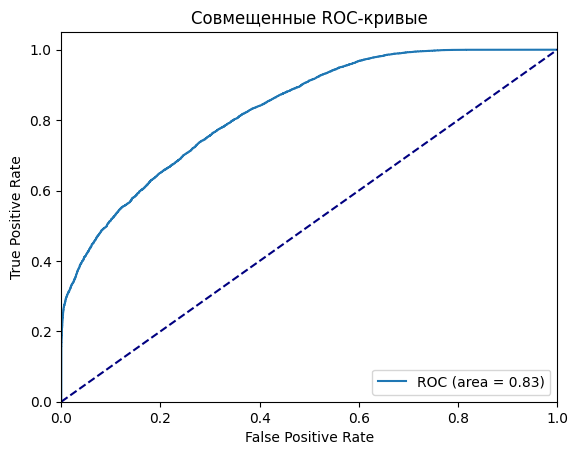

In [21]:
roc(final_res)

In [25]:
def confuns_matrix(train_rezalt_old):
    print(f'f1')
    print(f1_score(train_rezalt_old['true'].tolist(), [int(p>0.6) for p in train_rezalt_old['pred']], average='macro'))
    sns.heatmap(metrics.confusion_matrix(train_rezalt_old['true'],[int(p>0.6) for p in train_rezalt_old['pred']]),annot=True,cmap="Blues",square=True)
    plt.ylabel("label")
    plt.xlabel(f"")
    plt.title(f"Confusion matrix")
    plt.show()

f1
0.7065229843283505


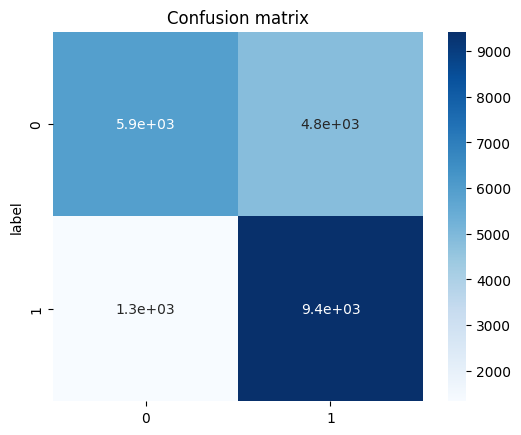

In [26]:
confuns_matrix(final_res)

In [27]:
final_res.to_csv("gen_rus_results.csv")